<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session9/S9V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-eyft5lsh
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-eyft5lsh
     |████████████████████████████████| 634kB 11.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=d75a737f5079775ff79de91782ce8c39ac774292e9e3bb7f5a7017f6cb937472
  Stored in directory: /tmp/pip-ephem-wheel-cache-o39vjgx4/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=162a15613d4f449d608cab631d5a84dc58a034dc4ead47bd2a0c31979b962a76
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
 

In [0]:
from torchvision import transforms
import albumentations as A
import albumentations.pytorch as AP
import random
import numpy as np
class AlbumentationTransforms:
  """
  Helper class to create test and train transforms using Albumentations
  """
  def __init__(self, transforms_list=[]):
    transforms_list.append(AP.ToTensor())

    self.transforms = A.Compose(transforms_list)


  def __call__(self, img):
    img = np.array(img)
    #print(img)
    return self.transforms(image=img)['image']


In [0]:

    
import torch
import torchvision
import torchvision.transforms as transforms
def load(train_transform,test_transform):
	
	trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
	testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()
	print("CUDA Available?", cuda)

	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

	classes = ('plane', 'car', 'bird', 'cat',
    	       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

	return classes, trainloader, testloader

In [0]:
import torch

#Training & Testing Loops
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, criterion, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
	
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss,test_acc

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False), #Rf = 3, j = 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p = 0.1),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #Rf = 5, j = 1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p = 0.1),

           
            
            )
        self.convblock2 = nn.Sequential(

            #Dilated Network
           nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1,dilation=2, bias=False), #jout=2, kernel_size = 5, rf = 6+(4)*2 = 14, o/p = 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p = 0.1),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #jout=2, kernel_size = 3, rf = 14+(2)*2 = 18, o/p =14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p = 0.1),

            
            )

        self.convblock3 = nn.Sequential(
            #DepthWise Seperable Network
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups = 32), # jout = 4, rf = 20+(2)*4 = 28, o/p = 7
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p = 0.1),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=1, bias=False), #jout = 4, rf = 28+(0)*4 = 28, o/p = 9
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p = 0.1),

            #DepthWise Seperable Network

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1,groups=64, bias=False),#jout = 4, rf = 28+(2)*4 = 36, o/p = 9
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p = 0.1),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), padding=1, bias=False), #jin = jout = 4, rf = 36+(0)*4 = 36, o/p = 11
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p = 0.1),
            
            )

        self.convblock4 = nn.Sequential(

            #Dialated Network
          nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1,dilation=2, bias=False), #jout = 8, rf = 40+(4)*8 = 72, o/p = 3
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.15),


            #AVG Pool

            nn.AdaptiveAvgPool2d(1), #op = 1



           nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)#Op_size = 1, 
            

            
            )



        self.pool = nn.MaxPool2d(2, 2)

      


    def forward(self, x):

        x = self.convblock1(x) # i/p= 32 o/p=32 Rf = 6
        x = self.pool(x) # jout = 2, Rf = 6, O/p = 16 
        x = self.convblock2(x) # Rf = 18 jout = 2, o/p =14
        x = self.pool(x) # jout = 4, s = 2, Rf = 18+1*2 = 20, o/p = 7
        x = self.convblock3(x) # jout = 4, Rf = 36, o/p = 11
        x = self.pool(x) # jout = 8, s = 2, Rf = 36+1*4 = 40 o/p = 5
        x = self.convblock4(x)  # o/p = 1
     
        x = x.view(-1, 10)
      
        return x




class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, in_planes, planes, stride=1, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.dropout = dropout
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.dropout)
        out = self.bn2(self.conv2(out))
        out = F.dropout(out, p=self.dropout)
        out += self.shortcut(x)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout)
        return out
 
 
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
 
 
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout=0.0):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.dropout = dropout
 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
 
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout=self.dropout))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.dropout)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
 
 
def ResNet18(dropout=0.0):
    return ResNet(BasicBlock, [2,2,2,2], dropout=dropout)
 
 
 
 


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    fig = plt.figure(figsize=(2,2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def show_misclassified_images(model, device, dataset, classes):
  misclassified_images = []
  
  for images, labels in dataset:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
              if(len(misclassified_images)<25 and predicted[i]!=labels[i]):
                misclassified_images.append([images[i],predicted[i],labels[i]])
            if(len(misclassified_images)>25):
              break
    
  
  fig = plt.figure(figsize = (8,8))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        #imshow(misclassified_images[i][0].cpu())
        img = misclassified_images[i][0].cpu()
        img = img / 2 + 0.5 
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1, 2, 0)),interpolation='none')
        
        sub.set_title("P={}, A={}".format(str(classes[misclassified_images[i][1].data.cpu().numpy()]),str(classes[misclassified_images[i][2].data.cpu().numpy()])))
        
  plt.tight_layout()


            

	# img_list = range(5, 10)

	# # print images
	# imshow(torchvision.utils.make_grid(images[img_list]))
	# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in img_list))

	# images = images.to(device)
	# outputs = model(images)

	# _, predicted = torch.max(outputs, 1)
	# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
  #                             for j in img_list))


def evaluate_accuracy(model, device, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            #print(len(credits))
            #print("***",c)
            for i in range(len(c)):
            	label = labels[i]
            	#print(c[i].item())
              
            	class_correct[label] += c[i].item()
            	#print(class_correct)
            	class_total[label] += 1
            	#print(class_total)

    
    
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


# functions to show an image
def imshow(img,c ):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(7,7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)



def show_random_images(dataset, classes):

	# get some random training images
  print(dataset)
  dataiter = iter(dataset)
  images, labels = dataiter.next()
  for i in range(10):
    index = [j for j in range(len(labels)) if labels[j] == i]
    imshow(torchvision.utils.make_grid(images[index[0:5]],nrow=5,padding=2,scale_each=True),classes[i])

  

	 
	

In [0]:
%matplotlib inline


In [0]:


import numpy as np

import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1,fill_value=0.5*255) # fillvalue is 0 after normalizing as mean is 0
                                       ])





# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


In [192]:
classes, trainloader, testloader = load()

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

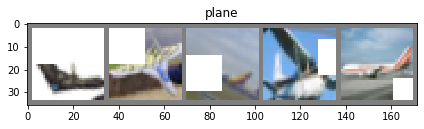

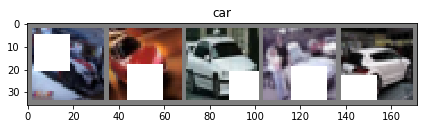

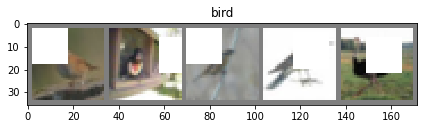

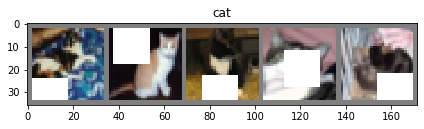

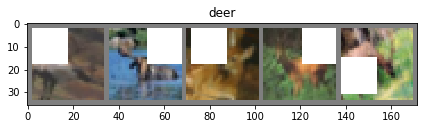

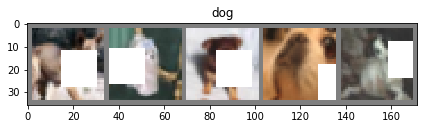

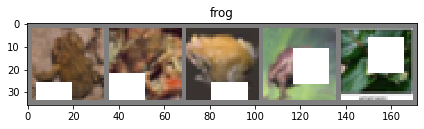

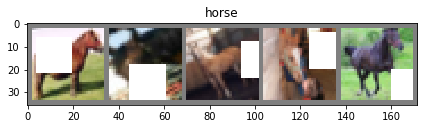

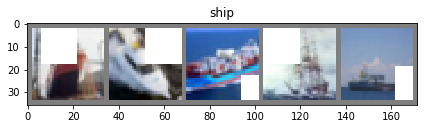

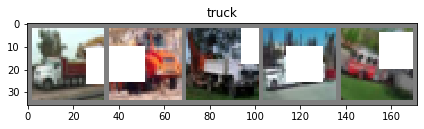

In [193]:
show_random_images(trainloader, classes)

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [14]:
testLoss = []
testAcc = []
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
    train(model, device, trainloader, optimizer, criterion, epoch)
    #scheduler.step()
    test_loss , test_acc = test(model, device, criterion, testloader)
    testLoss.append(test_loss)
    testAcc.append(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.1


Loss=1.9327352046966553 Batch_id=390 Accuracy=18.34: 100%|██████████| 391/391 [00:56<00:00,  6.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 2961/10000 (29.61%)

EPOCH: 2 LR: 0.1


Loss=1.8906772136688232 Batch_id=390 Accuracy=31.21: 100%|██████████| 391/391 [00:57<00:00,  6.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 3927/10000 (39.27%)

EPOCH: 3 LR: 0.1


Loss=1.6178014278411865 Batch_id=390 Accuracy=37.14: 100%|██████████| 391/391 [00:57<00:00,  6.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 4660/10000 (46.60%)

EPOCH: 4 LR: 0.1


Loss=1.5981948375701904 Batch_id=390 Accuracy=42.44: 100%|██████████| 391/391 [00:57<00:00,  6.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 4807/10000 (48.07%)

EPOCH: 5 LR: 0.1


Loss=1.172372579574585 Batch_id=390 Accuracy=47.12: 100%|██████████| 391/391 [00:58<00:00,  6.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 5675/10000 (56.75%)

EPOCH: 6 LR: 0.1


Loss=1.312314748764038 Batch_id=390 Accuracy=51.61: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 5978/10000 (59.78%)

EPOCH: 7 LR: 0.1


Loss=1.2698136568069458 Batch_id=390 Accuracy=55.07: 100%|██████████| 391/391 [00:59<00:00,  6.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 6056/10000 (60.56%)

EPOCH: 8 LR: 0.1


Loss=1.2116228342056274 Batch_id=390 Accuracy=57.76: 100%|██████████| 391/391 [00:58<00:00,  6.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 6620/10000 (66.20%)

EPOCH: 9 LR: 0.1


Loss=1.092515230178833 Batch_id=390 Accuracy=60.54: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6919/10000 (69.19%)

EPOCH: 10 LR: 0.1


Loss=1.0065926313400269 Batch_id=390 Accuracy=62.23: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7123/10000 (71.23%)

EPOCH: 11 LR: 0.1


Loss=1.110314130783081 Batch_id=390 Accuracy=64.32: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 7001/10000 (70.01%)

EPOCH: 12 LR: 0.1


Loss=0.8384754061698914 Batch_id=390 Accuracy=66.00: 100%|██████████| 391/391 [00:59<00:00,  6.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7382/10000 (73.82%)

EPOCH: 13 LR: 0.1


Loss=1.1525063514709473 Batch_id=390 Accuracy=67.51: 100%|██████████| 391/391 [00:59<00:00,  6.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7396/10000 (73.96%)

EPOCH: 14 LR: 0.1


Loss=0.9164489507675171 Batch_id=390 Accuracy=69.04: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7703/10000 (77.03%)

EPOCH: 15 LR: 0.1


Loss=0.5874689221382141 Batch_id=390 Accuracy=69.73: 100%|██████████| 391/391 [00:58<00:00,  6.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7580/10000 (75.80%)

EPOCH: 16 LR: 0.1


Loss=0.6722493767738342 Batch_id=390 Accuracy=71.18: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7848/10000 (78.48%)

EPOCH: 17 LR: 0.1


Loss=0.7016713619232178 Batch_id=390 Accuracy=71.66: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7809/10000 (78.09%)

EPOCH: 18 LR: 0.1


Loss=0.7459839582443237 Batch_id=390 Accuracy=72.81: 100%|██████████| 391/391 [00:58<00:00,  6.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8013/10000 (80.13%)

EPOCH: 19 LR: 0.1


Loss=0.8791539072990417 Batch_id=390 Accuracy=73.24: 100%|██████████| 391/391 [00:58<00:00,  6.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8056/10000 (80.56%)

EPOCH: 20 LR: 0.1


Loss=0.6648941040039062 Batch_id=390 Accuracy=74.07: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]



Test set: Average loss: 0.0044, Accuracy: 8093/10000 (80.93%)



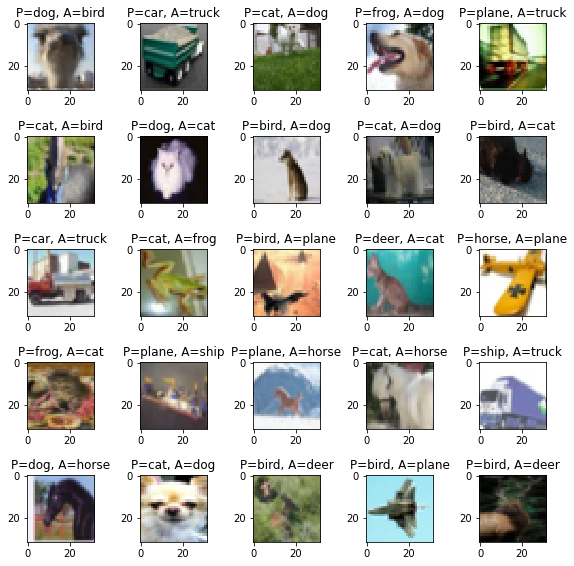

In [29]:
show_misclassified_images(model, device, testloader, classes)

In [16]:
evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 80 %


In [72]:
evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 83 %
Accuracy of   car : 96 %
Accuracy of  bird : 75 %
Accuracy of   cat : 61 %
Accuracy of  deer : 78 %
Accuracy of   dog : 64 %
Accuracy of  frog : 90 %
Accuracy of horse : 81 %
Accuracy of  ship : 93 %
Accuracy of truck : 85 %


Text(0.5, 1.0, 'Test Accuracy')

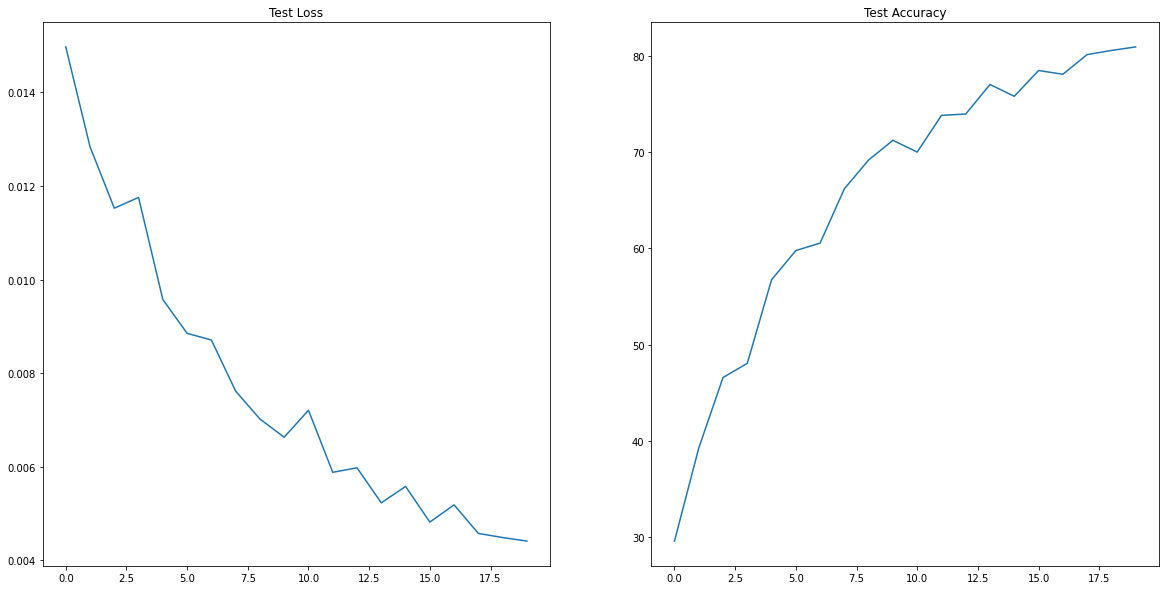

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(testLoss)
axs[0].set_title("Test Loss")


axs[1].plot(testAcc[0])
axs[1].set_title("Test Accuracy")



** 0 ('', ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.

In [0]:
from torch.nn import functional as F
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers 
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output):
            
              self.fmap_pool[key] = output.detach()

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out):
              self.grad_pool[key] = grad_out[0].detach()

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        print('self.nll',self.nll)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size duign forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

def GRADCAM(images, labels, model, target_layers):
  model.eval()
  # map input to device
  images = torch.stack(images).to(device)
  # set up grad cam
  gcam = GradCAM(model, target_layers)
  # forward pass
  probs, ids = gcam.forward(images)
  print(probs,ids)
  # outputs agaist which to compute gradients
  a = torch.LongTensor(labels)
  b = a.view(len(images),-1).to(device)
  # backward pass
  gcam.backward(ids=b)
  layers = []
  for i in range(len(target_layers)):
    target_layer = target_layers[i]
    print("Generating Grad-CAM @{}".format(target_layer))
    # Grad-CAM
    layers.append(gcam.generate(target_layer=target_layer))
  # remove hooks when done
  gcam.remove_hook()
  return layers, probs, ids

def PLOT(gcam_layers, images, labels, target_layers, class_names, image_size, predicted, unnormalize):
    c = len(images)+1
    r = len(target_layers)+2
    fig = plt.figure(figsize=(32,14))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=14)
    plt.axis('off')
    for i in range(len(target_layers)):
      target_layer = target_layers[i]
      ax = plt.subplot(r, c, c*(i+1)+1)
      ax.text(0.3,-0.5, target_layer, fontsize=14)
      plt.axis('off')

      for j in range(len(images)):
        img = np.uint8(255*unnormalize(images[j].view(image_size)))
        if i==0:
          ax = plt.subplot(r, c, j+2)
          ax.text(0, 0.2, f"pred={class_names[predicted[j][0]]}\n[actual={class_names[labels[j]]}]", fontsize=14)
          plt.axis('off')
          plt.subplot(r, c, c+j+2)
          plt.imshow(img, interpolation='bilinear')
          plt.axis('off')


        heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
        plt.subplot(r, c, (i+2)*c+j+2)
        plt.imshow(superimposed_img, interpolation='bilinear')

        plt.axis('off')
    plt.show() 


self.nll tensor([[ 0.0518, -0.0025,  0.0280,  0.0201,  0.0123, -0.0172,  0.0028, -0.0450,
         -0.0046, -0.0063],
        [ 0.0524, -0.0073,  0.0313,  0.0155,  0.0014, -0.0041, -0.0089, -0.0425,
         -0.0105, -0.0084],
        [ 0.0635, -0.0132,  0.0229,  0.0126,  0.0006, -0.0150,  0.0019, -0.0412,
         -0.0069, -0.0044],
        [ 0.0572, -0.0084,  0.0338,  0.0152,  0.0077, -0.0123,  0.0048, -0.0355,
         -0.0058, -0.0129],
        [ 0.0488, -0.0065,  0.0235,  0.0156,  0.0119, -0.0032,  0.0081, -0.0426,
         -0.0112, -0.0111],
        [ 0.0695, -0.0029,  0.0306,  0.0208,  0.0068, -0.0111,  0.0016, -0.0537,
         -0.0059, -0.0152],
        [ 0.0462, -0.0074,  0.0218,  0.0094,  0.0066, -0.0058,  0.0093, -0.0399,
         -0.0100, -0.0016],
        [ 0.0612,  0.0011,  0.0268,  0.0255,  0.0017, -0.0079, -0.0014, -0.0480,
         -0.0142, -0.0121],
        [ 0.0436, -0.0123,  0.0205,  0.0201,  0.0081, -0.0078,  0.0020, -0.0404,
         -0.0055,  0.0036],
        [ 

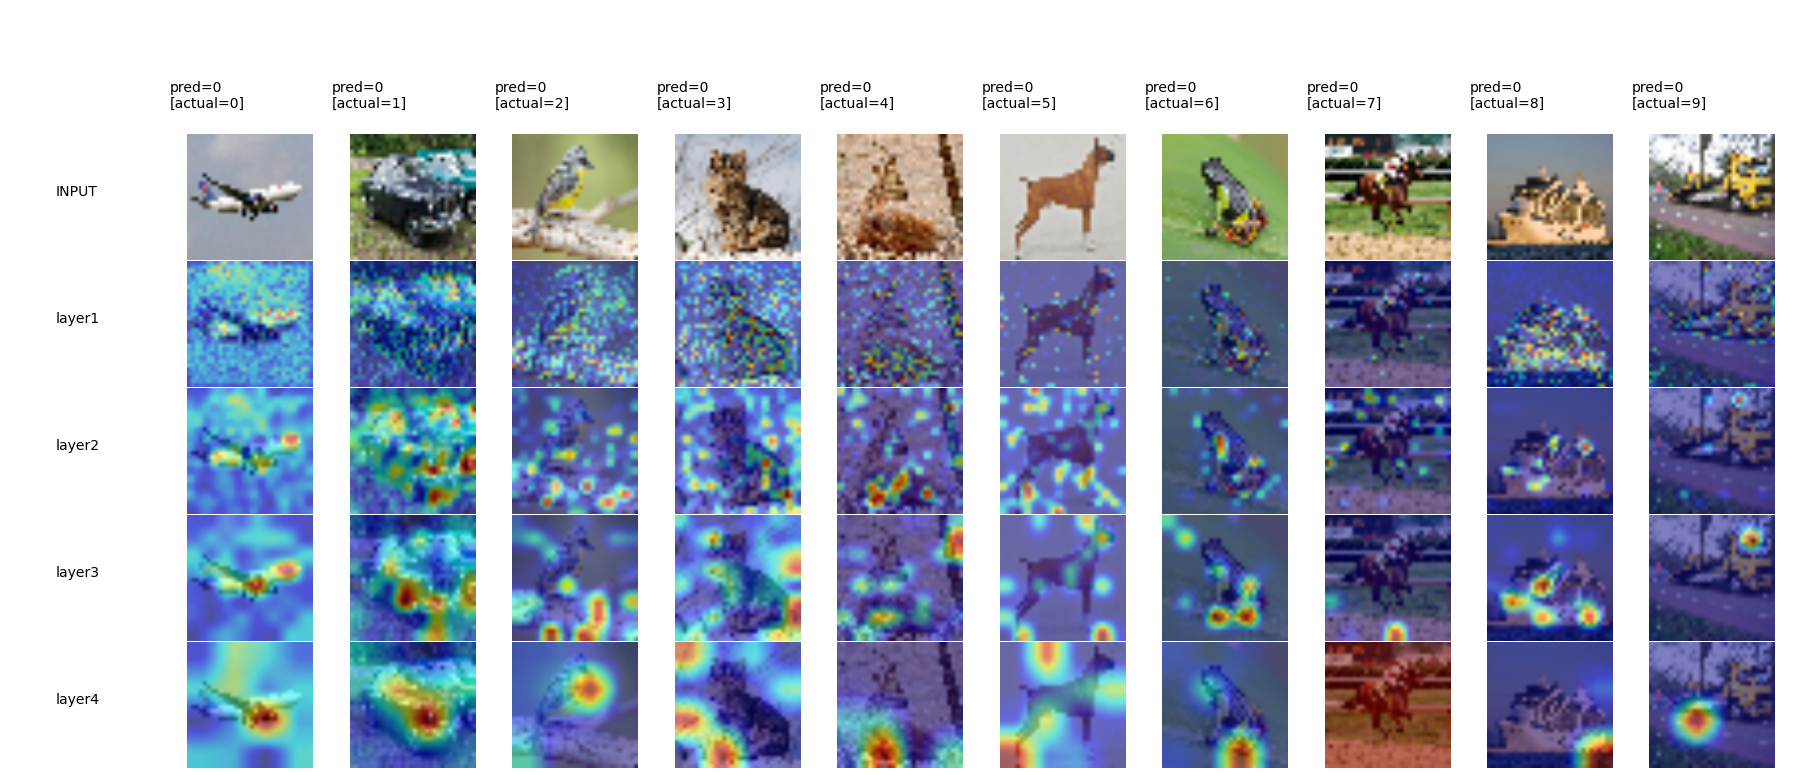

In [160]:
target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = GRADCAM(images, target_classes, model, target_layers)
PLOT(gradcam_output, images, target_classes, target_layers, target_classes, (3, 32, 32), predicted_classes, unnormalize)

In [0]:
in_images = [
          (0, 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Egyptair.a330-200.su-gce.arp.jpg/1200px-Egyptair.a330-200.su-gce.arp.jpg'),
          (1, 'https://upload.wikimedia.org/wikipedia/commons/5/5b/Riley_4-68_Riviera_1961.jpg'),
          (2, 'https://upload.wikimedia.org/wikipedia/commons/4/45/Eopsaltria_australis_-_Mogo_Campground.jpg'),
          (3, 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/800px-Cat_November_2010-1a.jpg'),
          (4, 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Spotted_deer_in_S.V._zoo%2C_Tirupathi_%28May_2019%29.jpg/1920px-Spotted_deer_in_S.V._zoo%2C_Tirupathi_%28May_2019%29.jpg'),
          (5, 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/%22Boxer_dog%22_stand.jpg/1280px-%22Boxer_dog%22_stand.jpg'),
          (6, 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg/800px-Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg'),
          (7, 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Horseracing_Churchill_Downs.jpg/1920px-Horseracing_Churchill_Downs.jpg'),
          (8, 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Marina_%28ship%2C_2011%29%2C_S%C3%A8te_01.jpg/1920px-Marina_%28ship%2C_2011%29%2C_S%C3%A8te_01.jpg'),
          (9, 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Bergingstruck_%28tow_truck%29.jpg/1280px-Bergingstruck_%28tow_truck%29.jpg')
]
#
images = []
target_classes = []

for i in in_images:
  images.append(getimage(i[1], test_transform))
  target_classes.append(i[0])

In [0]:
import cv2
import urllib
import numpy as np
from google.colab.patches import cv2_imshow

def getimage(img, transform, input_size=(32,32)):
  if img.startswith("http"):
      req = urllib.request.urlopen(img)
      arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
      img = cv2.imdecode(arr, -1) # 'Load it as it is'
  else:
    img = cv2.imread(img, 1)
  
  img = img[:,:, -1::-1]
  
  img = np.uint8(cv2.resize(img, input_size))

  return transform(img)

In [145]:
test_transform

In [147]:
 a = torch.randn([1, 1, 1])
 b = torch.randn([1,1,1])
 print(a,b)

tensor([[[0.4991]]]) tensor([[[-1.2138]]])


In [149]:
torch.stack([a,b])

tensor([[[[ 0.4991]]],


        [[[-1.2138]]]])

In [0]:
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))